**Check Python Version**

In [1]:
!python -V

Python 3.10.17


**Imports**

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# Scikit-Learn imports
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

**Get the dataset**

Get the data [here](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

In [3]:
!mkdir data
!wget -qq https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet
!mv green_tripdata_2021-01.parquet data
print(os.listdir("data"))

mkdir: cannot create directory ‘data’: File exists
['green_tripdata_2021-01.parquet']


In [4]:
df = pd.read_parquet("data/green_tripdata_2021-01.parquet")
print(df.shape)

(76518, 20)


In [5]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               76518 non-null  int64         
 1   lpep_pickup_datetime   76518 non-null  datetime64[us]
 2   lpep_dropoff_datetime  76518 non-null  datetime64[us]
 3   store_and_fwd_flag     40471 non-null  object        
 4   RatecodeID             40471 non-null  float64       
 5   PULocationID           76518 non-null  int64         
 6   DOLocationID           76518 non-null  int64         
 7   passenger_count        40471 non-null  float64       
 8   trip_distance          76518 non-null  float64       
 9   fare_amount            76518 non-null  float64       
 10  extra                  76518 non-null  float64       
 11  mta_tax                76518 non-null  float64       
 12  tip_amount             76518 non-null  float64       
 13  t

**Relevant columns**

- `PULocationID`: Pickup location ID
- `DOLocationID`: Dropoff location ID
- `trip_distance`: Distance that was driven between pickup and dropoff location

**Parse `datetime64` strings correctly**

In [16]:
df["lpep_pickup_datetime"] = pd.to_datetime(df["lpep_pickup_datetime"])
df["lpep_dropoff_datetime"] = pd.to_datetime(df["lpep_dropoff_datetime"])

df["duration"] = df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"]
df["duration"] = df["duration"].apply(lambda td: td.total_seconds() / 60)

In [15]:
print(df["duration"].head(3))

0    3.933333
1    8.750000
2    5.966667
Name: duration, dtype: float64


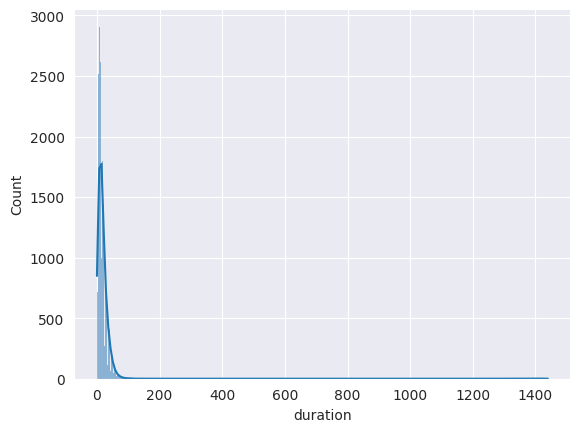

In [18]:
sns.histplot(df["duration"], kde=True);

**The distribution has a very long tail**

In [19]:
df["duration"].describe()

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
25%          8.000000
50%         13.883333
75%         23.000000
max       1439.600000
Name: duration, dtype: float64

There are very long and very short trips.

In [20]:
df["duration"].describe(percentiles=[0.95, 0.98, 0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

$98\%$ of the data lies in the range of 60 minutes and below. We will focus on this data range. Other values will be handled as outliers and are dropped.

In [21]:
mask = (df["duration"] >= 0) & (df["duration"] <= 60)
print(mask.mean())
df = df[mask]

0.9848140306855904


# Filter out the relevant columns

In [22]:
categorical = ["PULocationID", "DOLocationID"]
numerical = ["trip_distance"]

In [23]:
# categorical features are integer values
df[categorical].dtypes

PULocationID    int64
DOLocationID    int64
dtype: object

In [29]:
df[categorical] = df[categorical].astype(str)
print(df[categorical].dtypes)

PULocationID    object
DOLocationID    object
dtype: object


In [30]:
print(df.dtypes)

VendorID                          int64
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                     object
DOLocationID                     object
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
dtype: object


In [31]:
train_dicts = df[categorical + numerical].to_dict(orient="records")

Transform categorical features into 1-Hot encoded representation

In [33]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [38]:
print(X_train.shape)
print("dv.feature_names: \n", "\n".join(dv.feature_names_))

(75356, 508)
dv.feature_names: 
 DOLocationID=1
DOLocationID=10
DOLocationID=100
DOLocationID=101
DOLocationID=102
DOLocationID=106
DOLocationID=107
DOLocationID=108
DOLocationID=109
DOLocationID=11
DOLocationID=111
DOLocationID=112
DOLocationID=113
DOLocationID=114
DOLocationID=115
DOLocationID=116
DOLocationID=117
DOLocationID=118
DOLocationID=119
DOLocationID=12
DOLocationID=120
DOLocationID=121
DOLocationID=122
DOLocationID=123
DOLocationID=124
DOLocationID=125
DOLocationID=126
DOLocationID=127
DOLocationID=128
DOLocationID=129
DOLocationID=13
DOLocationID=130
DOLocationID=131
DOLocationID=132
DOLocationID=133
DOLocationID=134
DOLocationID=135
DOLocationID=136
DOLocationID=137
DOLocationID=138
DOLocationID=139
DOLocationID=14
DOLocationID=140
DOLocationID=141
DOLocationID=142
DOLocationID=143
DOLocationID=144
DOLocationID=145
DOLocationID=146
DOLocationID=147
DOLocationID=148
DOLocationID=149
DOLocationID=15
DOLocationID=150
DOLocationID=151
DOLocationID=152
DOLocationID=153
DOLoca

In [39]:
target = "duration"
y_train = df[target].values

In [40]:
print(y_train.shape)

(75356,)


In [41]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [42]:
y_pred = model.predict(X_train)

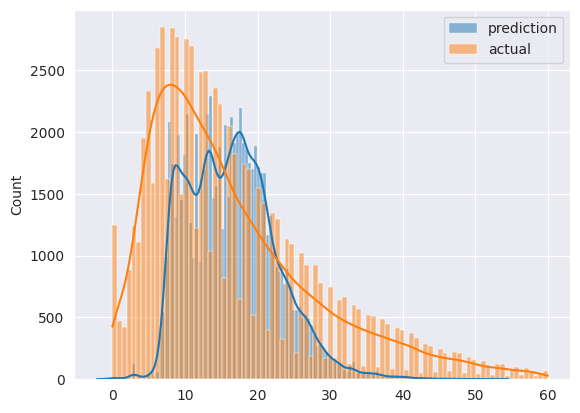

In [44]:
sns.histplot(y_pred, label="prediction", kde=True)
sns.histplot(y_train, label="actual", kde=True)
plt.legend()
plt.show()

In [47]:
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print(f"RMSE(train): {rmse:.2f}")

RMSE(train): 9.93


**Get validation data**

In [48]:
!wget -qq https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet
!mv green_tripdata_2021-02.parquet data
print(os.listdir("data"))

['green_tripdata_2021-01.parquet', 'green_tripdata_2021-02.parquet']


In [49]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    print(df.shape)

    # Create duration-column in minunute format
    df["lpep_pickup_datetime"] = pd.to_datetime(df["lpep_pickup_datetime"])
    df["lpep_dropoff_datetime"] = pd.to_datetime(df["lpep_dropoff_datetime"])

    df["duration"] = df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"]
    df["duration"] = df["duration"].apply(lambda td: td.total_seconds() / 60)

    # Remove outliers 
    mask = (df["duration"] >= 0) & (df["duration"] <= 60)
    df = df[mask].copy()
    
    categorical = ["PULocationID", "DOLocationID"]
    numerical = ["trip_distance"]

    df[categorical] = df[categorical].astype(str)

    return df


df_val = read_dataframe("data/green_tripdata_2021-02.parquet")

(64572, 20)


In [50]:
val_dicts = df_val[categorical + numerical].to_dict(orient="records")

In [51]:
X_val = dv.transform(val_dicts)

In [52]:
target = "duration"
y_val = df_val[target].values

In [53]:
print("X(val): ", X_val.shape)
print("y(val): ", y_val.shape)

X(val):  (63050, 508)
y(val):  (63050,)


In [56]:
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE(val): {rmse:.2f}")

RMSE(val): 10.59


**Trying out Lasso-Regression**

In [58]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

10.57410911205217

**Trying out Ridge-Regression**

In [59]:
rr = Ridge()
rr.fit(X_train, y_train)
y_pred = rr.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

10.571460096360829

## Useing different features

In [60]:
df_train = read_dataframe("data/green_tripdata_2021-01.parquet")
df_val = read_dataframe("data/green_tripdata_2021-02.parquet")

(76518, 20)
(64572, 20)


In [61]:
df_train["PU_DO"] = df_train["PULocationID"] + "_" + df_train["DOLocationID"]
df_val["PU_DO"] = df_val["PULocationID"] + "_" + df_val["DOLocationID"]
df_train.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,PU_DO
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333,43_151
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000,166_239
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667,41_42
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333,168_75
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,...,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00,0.066667,265_265


In [62]:
categorical = ["PU_DO"]
numerical = ["trip_distance"]

dv = DictVectorizer()
train_dicts = df_train[categorical + numerical].to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)
val_dicts = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dicts)

In [63]:
target = "duration"
y_train = df_train[target].values
y_val = df_val[target].values

### Training some linear models and evaluating them

**Linear-Regression**

In [64]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

7.808922487080116

**Lasso-Regression**

In [65]:
lr_1 = Lasso()
lr_1.fit(X_train, y_train)
y_pred = lr_1.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

12.325863638829496

**Ridge-Regression**

In [66]:
lr_2 = Ridge()
lr_2.fit(X_train, y_train)
y_pred = lr_2.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

7.7166579358044896

## Saving a good model

In [67]:
import pickle

**The saved model will be used throughout the whole course**

In [69]:
model_folder = "./models/"
if not os.path.exists(model_folder):
    os.mkdir(model_folder)

with open("./models/_lin_reg.bin", "wb") as f_out:
    pickle.dump((dv, lr), f_out)